# Прогнозирование оттока пользователей фитнес-центра
<br>
Заказчик предоставил персональные данные пользователей и информацию из журнала посещений, покупок в csv файле. Представленная информация содержит данные на месяц до оттока и факт оттока на определенный месяц. Нам необходимо <b> провести исследовательский анализ данных</b>, <b> построить модель машинного обучения, которая спрогнозирует отток пользователей</b> и <b> провести кластеризацию клиентов</b>.
Разделим данное исследование на несколько шагов:<br>

## <a href='#section1'>1 Загрузка данных и подготовка к анализу</a><br>
## <a href='#section2'>2 Исследовательский анализ данных</a><br>
### <a href='#section21'>2.1 Изучение статистических показателей</a><br>
### <a href='#section22'>2.2 Сравнение средних значений между теми, кто остался и ушел в отток</a><br>
### <a href='#section23'>2.3 Построение гистограмм и распределений</a><br>
### <a href='#section24'>2.4 Построение матрицы корреляций</a><br>
## <a href='#section3'>3 Создание модели прогнозирования</a><br>
### <a href='#section31'>3.1 Разделение данных на выборки</a><br>
### <a href='#section32'>3.2 Обучение моделей и оценка метрик. Выбор лучшей модели</a><br>
## <a href='#section4'>4 Кластеризация клиентов</a><br>
### <a href='#section41'>4.1 Стандартизация данных</a><br>
### <a href='#section42'>4.2 Матрица расстояний. Дендрограмма</a><br>
### <a href='#section43'>4.3 Обучение модели кластеризации</a><br>
### <a href='#section44'>4.4 Распределение признаков для кластеров</a><br>
### <a href='#section45'>4.5 Отток по кластерам</a><br>
## <a href='#section5'>Выводы и рекомендации</a><br>


## <a id='section1'>1 Загрузка данных и подготовка к анализу</a><br>

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,\
                            GradientBoostingClassifier
from sklearn.metrics import accuracy_score,\
                            precision_score,\
                            recall_score,\
                            f1_score,\
                            roc_auc_score
from scipy.cluster.hierarchy import dendrogram,\
                                    linkage
!pip install seaborn -U
import seaborn as sns
import matplotlib.pyplot as plt
#Настраиваем стиль графиков
plt.style.use('seaborn-pastel')
large = 14; med = 12; small = 10
params = {'figure.figsize': (10,5),
          'axes.grid' : True,
          'grid.alpha': 0.3,
          'axes.titlesize': med,
          'axes.titleweight': 'light',
          'axes.labelweight': 'light',
          'legend.fontsize': small,
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large
          }
plt.rcParams.update(params)
sns.set_style('darkgrid')
sns.set_palette('Set2')

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [2]:
#Получаем файл с данными
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
#Приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

## <a id='section2'>2 Исследовательский анализ данных</a><br>

### <a id='section21'>2.1 Изучение статистических показателей</a><br>

In [4]:
#Проверяем датафрейм на ошибки 
display(data.describe(), data.info(), data.duplicated().unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


None

array([False])

Для каждого из параметров имеется 4000 наблюдений. Дубликаты и пропуски отсутствуют. Типы данных соответствуют нашим задачам. Средние значения разных параметров сильно различаются: от 0.31 до 146.94, как и стандартные отклонения, поэтому данные нуждаются в стандартизации.

### <a id='section22'>2.2 Сравнение средних значений между теми, кто остался и ушел в отток</a><br>

In [5]:
#сгруппируем датафрейм для определения средних значений признаков
data_grouped_mean = data.groupby('churn').agg('mean').reset_index(drop=True)
data_grouped_mean.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Ряд признаков у тех кто ушел в отток различается, в то время как другие примерно равны. Давайте посмотрим на визуальное распередение.

### <a id='section23'>2.3 Построение гистограмм и распределений</a><br>

Средние значения для признака: gender


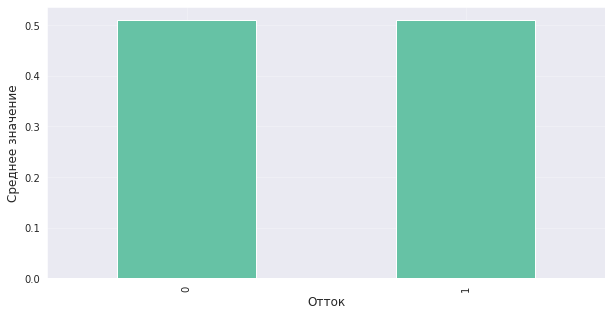

Средние значения для признака: near_location


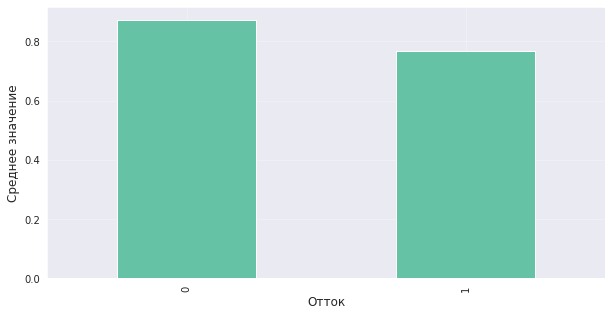

Средние значения для признака: partner


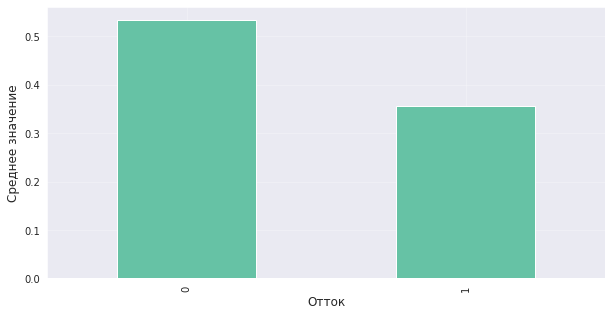

Средние значения для признака: promo_friends


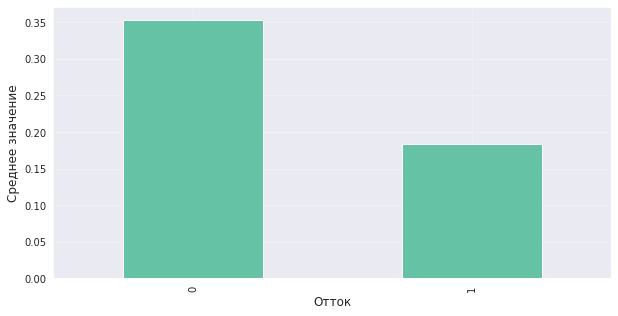

Средние значения для признака: phone


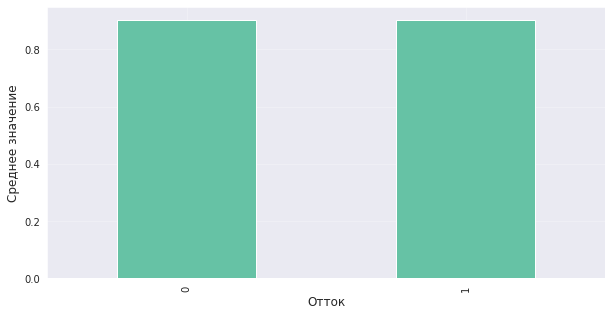

Средние значения для признака: contract_period


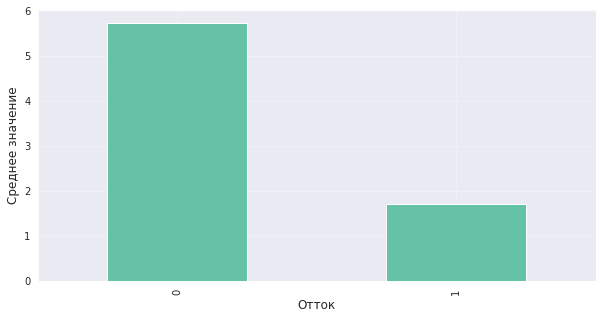

Средние значения для признака: group_visits


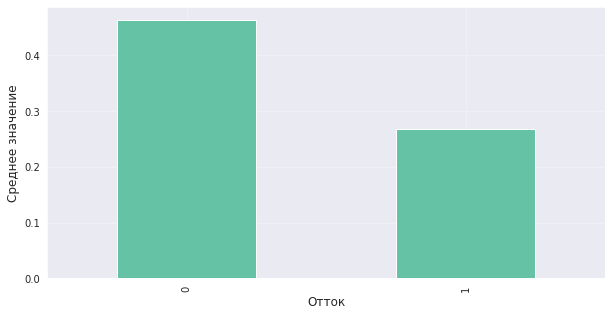

Средние значения для признака: age


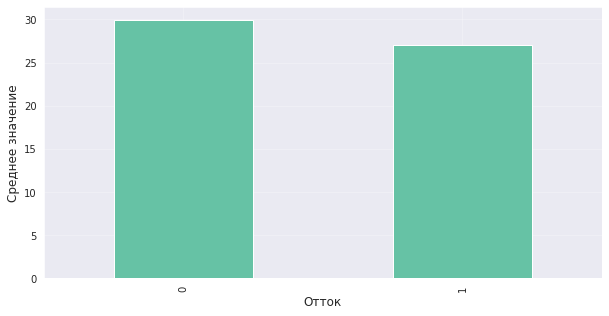

Средние значения для признака: avg_additional_charges_total


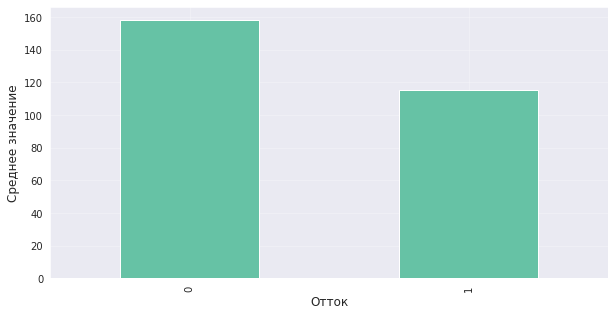

Средние значения для признака: month_to_end_contract


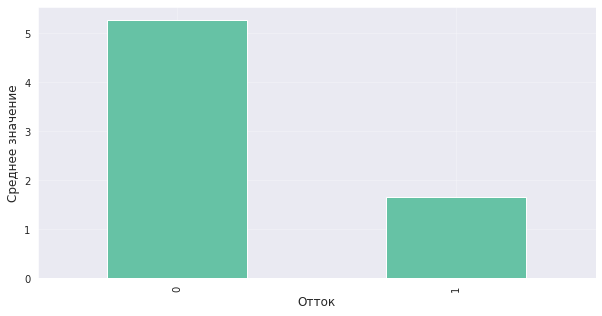

Средние значения для признака: lifetime


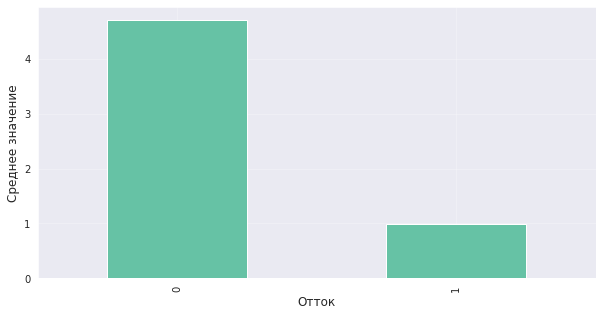

Средние значения для признака: avg_class_frequency_total


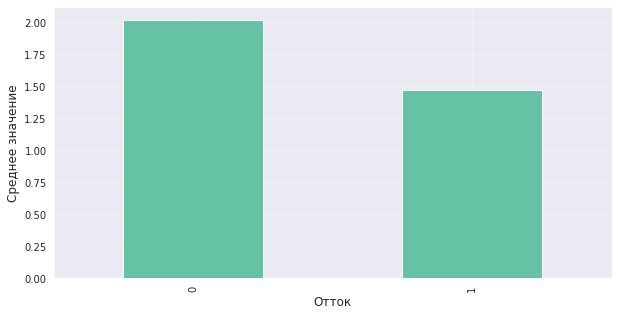

Средние значения для признака: avg_class_frequency_current_month


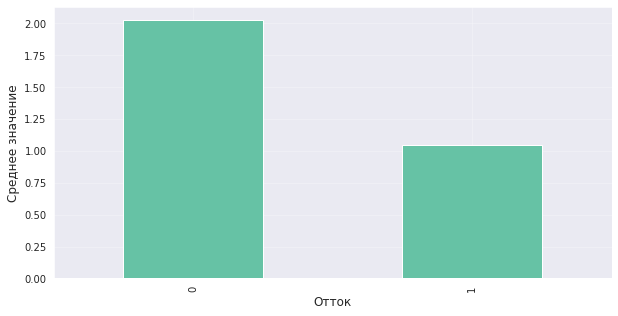

In [6]:
#Создадим визуализацию для каждого из признаков
for col in data_grouped_mean.columns:
    print("Средние значения для признака:", col)
    data_grouped_mean[col].plot(kind="bar")
    plt.xlabel('Отток')
    plt.ylabel('Среднее значение')
    plt.show()


Для пользователей, сгруппированных по оттоку, похожие средние значения остаются у признаков: gender, phone, в меньшей степени у near_location и age. Все остальные средние значения имеют бОльший разрыв: сюда относятся признаки: partner, promo_friends,  contract_period, group_visits, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month. 

Предварительно можно заключить, что больше всего на отток влияют экономические факторы (условия контракта, платежеспособность клиентов) и факторы мотивации (Для чего посещать центр? С кем? Как часто и почему?).

Распределение значений для признака: gender


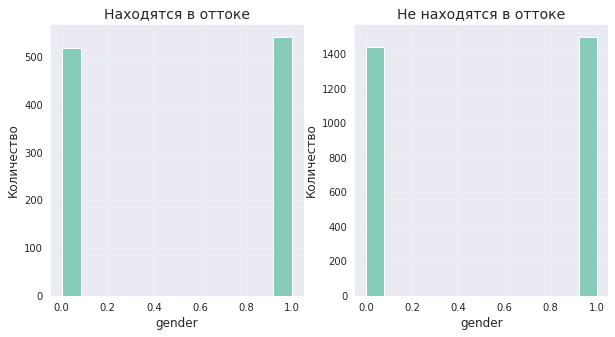

Распределение значений для признака: near_location


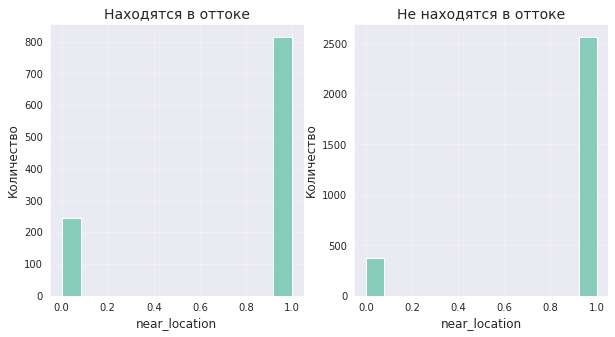

Распределение значений для признака: partner


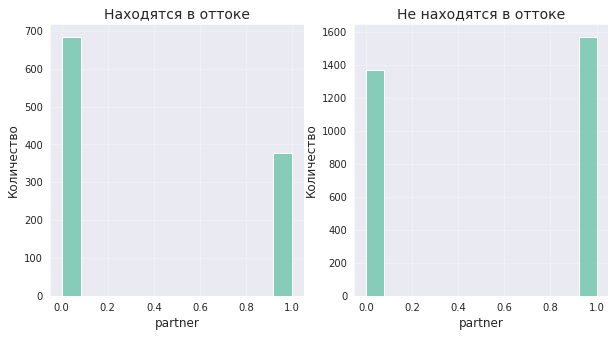

Распределение значений для признака: promo_friends


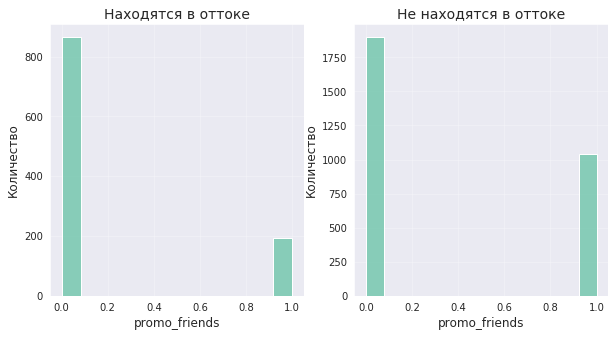

Распределение значений для признака: phone


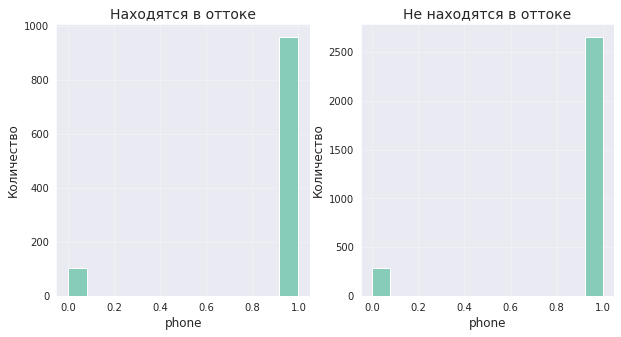

Распределение значений для признака: contract_period


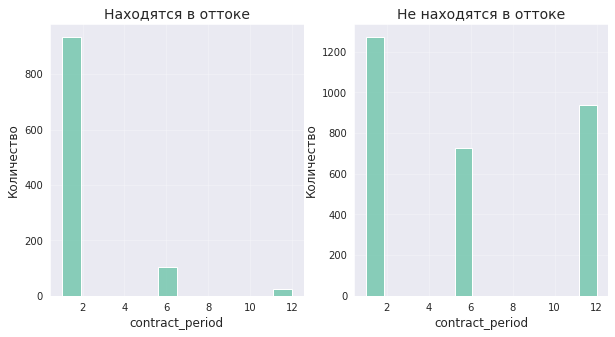

Распределение значений для признака: group_visits


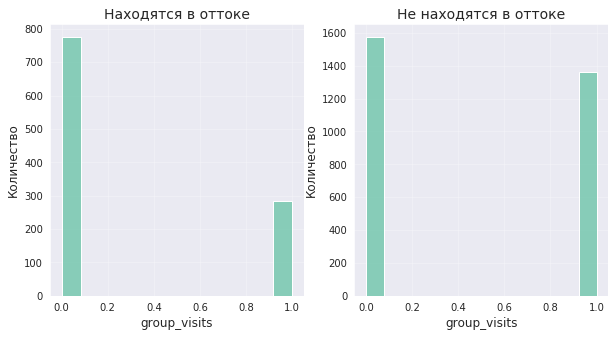

Распределение значений для признака: age


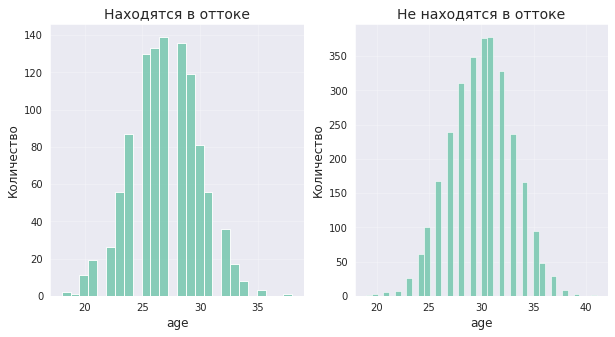

Распределение значений для признака: avg_additional_charges_total


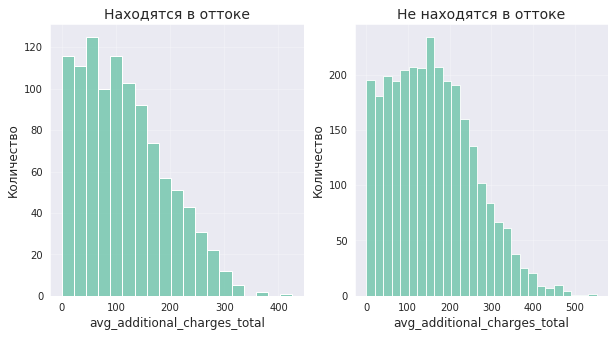

Распределение значений для признака: month_to_end_contract


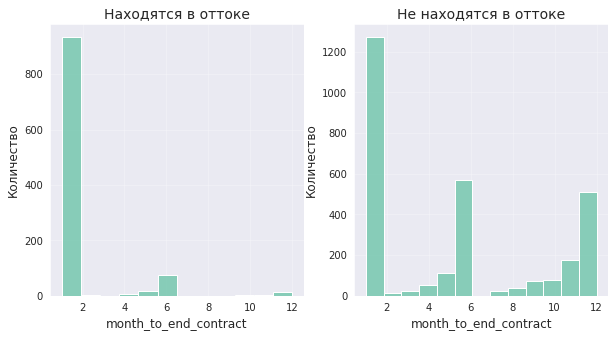

Распределение значений для признака: lifetime


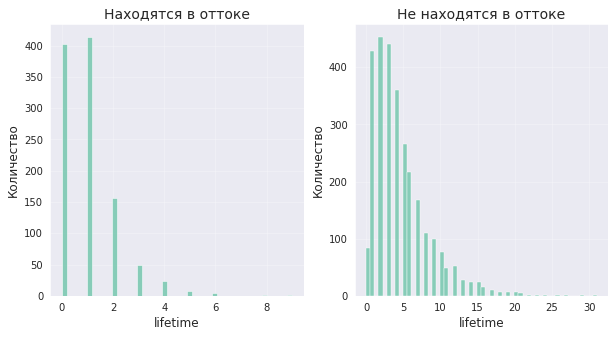

Распределение значений для признака: avg_class_frequency_total


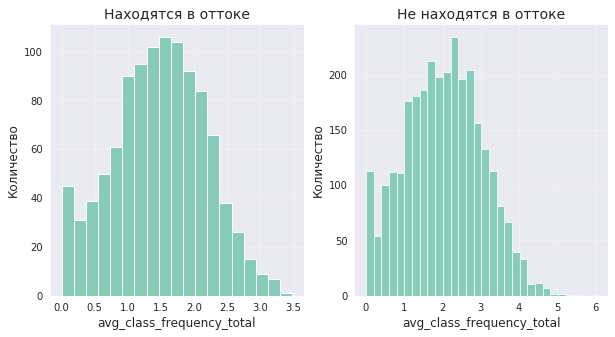

Распределение значений для признака: avg_class_frequency_current_month


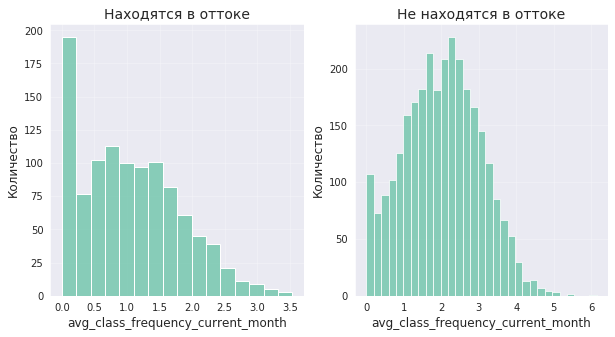

In [7]:
#Создадим визуализацию распределения для каждого из признаков
for col in data_grouped_mean.columns:
    print("Распределение значений для признака:", col)
    plt.subplot(1, 2, 1)
    sns.histplot(data[data['churn'] == 1][col])
    plt.title('Находятся в оттоке')
    plt.ylabel('Количество')
    plt.subplot(1, 2, 2)
    sns.histplot(data[data['churn'] == 0][col])
    plt.title('Не находятся в оттоке')
    plt.ylabel('Количество')
    plt.show()



Характер распределения у признаков показывает, что бОльшая часть клиентов находятся неподалеку, пришли без промо от друзей, имеют телефон, заключают контракты на 1 месяц, приходят по одиночке, имеют возраст от 25 до 35 лет, не склонны платит дополнительно более 300 рублей, посещают центр до 5 месяцев, приходят не чаще 3 раз в неделю. 

Различия между распределениями у тех, кто в оттоке и нет имеются только у некоторых признаков. Так, те кто находятся далеко от центра чаще попадают в отток. У тех, кто в оттоке чаще не бывает партнера, чем у тех, кто не находится в оттоке. Те, кто не пришел по promo от друзей, чаще находятся в оттоке (также те, кто находятся в оттоке меньше совершают групповые визиты). Чаще всего в отток попадают клиенты с контрактом на 1 месяц. Чаще в отток попадают клиенты, у которых остается один месяц до конца контракта. Чаще в отток попадают клиенты с меньшим количеством месяцев посещения центра. Те, кто в текущем месяце чаще пользуются услугами центра, меньше находятся в оттоке.

### <a id='section24'>2.4 Построение матрицы корреляций</a><br>

In [8]:
data.corr().style.background_gradient(cmap='coolwarm')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1,0.00669923,-0.0104626,-0.00503327,-0.00854212,0.000502261,0.0178789,0.0138069,-0.00933444,-0.00128079,0.0135786,0.0146202,0.00915649,0.000707734
near_location,0.00669923,1,-0.00511943,0.210964,-0.0157632,0.150233,0.154728,0.0583578,0.0407612,0.143961,0.0709206,0.0431275,0.0626636,-0.128098
partner,-0.0104626,-0.00511943,1,0.45196,0.00996961,0.306166,0.0227096,0.0474797,0.0229412,0.294632,0.0612294,0.0249379,0.0455611,-0.157986
promo_friends,-0.00503327,0.210964,0.45196,1,0.00198159,0.244552,0.12017,0.0501133,0.0368977,0.239553,0.0727211,0.0280632,0.0537684,-0.162233
phone,-0.00854212,-0.0157632,0.00996961,0.00198159,1,-0.00689326,-0.0100991,-0.0114032,0.00927943,-0.0111963,-0.0188012,0.00834047,0.0133749,-0.0011766
contract_period,0.000502261,0.150233,0.306166,0.244552,-0.00689326,1,0.169991,0.138249,0.111445,0.973064,0.170725,0.0962111,0.159407,-0.389984
group_visits,0.0178789,0.154728,0.0227096,0.12017,-0.0100991,0.169991,1,0.0809336,0.0320791,0.163703,0.0758528,0.0566948,0.0759233,-0.175325
age,0.0138069,0.0583578,0.0474797,0.0501133,-0.0114032,0.138249,0.0809336,1,0.0802401,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.00933444,0.0407612,0.0229412,0.0368977,0.00927943,0.111445,0.0320791,0.0802401,1,0.113958,0.0790283,0.0444264,0.0795697,-0.198697
month_to_end_contract,-0.00128079,0.143961,0.294632,0.239553,-0.0111963,0.973064,0.163703,0.134511,0.113958,1,0.161078,0.0853867,0.147605,-0.381393


Согласно матрице корреляций, сильнее всего на отток влияют период контракта, возраст, продолжительность занятий в центре, количество месяцев до конца контракта и средняя недельная посещаемость в текущем месяце. Это косвенно подтверждает полученные ранее выводы. Встречаются две пары сильно коррелирующих признаков: avg_class_frequency_current_month и avg_class_frequency_total, а также month_to_end_contract	и contract_period. оставим только признаки, которые отражают последние данные (среднее количество посещений в текущем месяце и количество месяцев до конца контракта), поскольку в моменте они точнее покажут настроения клиентов.

In [9]:
data.drop('contract_period', axis=1, inplace=True)
data.drop('avg_class_frequency_total', axis=1, inplace=True)

## <a id='section3'>3 Создание модели прогнозирования</a><br>

Выбранная нами модель в конечном счете должна решать задачу <b>обучения с учителем (бинарной классификации)</b>. Для этого мы попробуем такие варанты, как <i>логистическая регрессия, дерево принятия решений, случайны лес, градиентный бустинг</i>.

### <a id='section31'>3.1 Разделение данных на выборки</a><br>

In [10]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'], axis=1)
y = data['churn']
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train)  
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### <a id='section32'>3.2 Обучение моделей и оценка метрик. Выбор лучшей модели</a><br>

In [11]:
# задаем список рекомендуемых моделей
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    DecisionTreeClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state=0)
]

#создадим функцию, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_test, y_proba)))

    
#напишем цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test
    )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.84
	F1: 0.84
	ROC_AUC: 0.97
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
	Accuracy: 0.88
	Precision: 0.76
	Recall: 0.79
	F1: 0.78
	ROC_AUC: 0.85
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', 

По показателям метрик модель логистической регрессии превосходит модель случайного леса по доли правильных ответов(accuracy), полноте (recall), f1-score и площади под кривой ошибок(roc_auc), но незначительно уступает по точности(precision). Логистическая регрессия - оптимальный выбор в данном случае.

## <a id='section4'>4 Кластеризация клиентов</a><br>

Нам необходимо провести кластеризацию клиентов, то есть решить задачу <b>обучения без учителя</b> Мы будем использовать алгорити <b>K-Means</b>. Число кластеров выберем 5, как указано в проектном задании.

### <a id='section41'>4.1 Стандартизация данных</a><br>

In [12]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(X)

### <a id='section42'>4.2 Матрица расстояний. Дендрограмма</a><br>

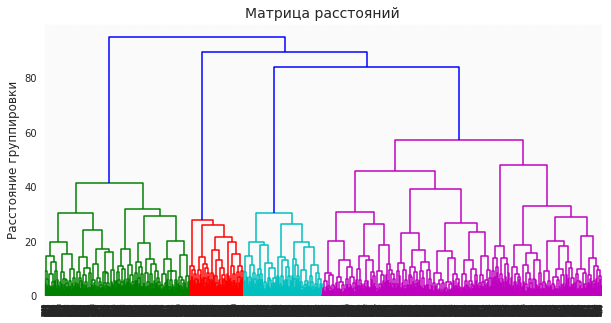

In [13]:
#Нарисуем дендрограмму
linked = linkage(x_sc, method='ward')
dendrogram(linked, orientation='top')
plt.title('Матрица расстояний')
plt.ylabel('Расстояние группировки')
plt.show()

Дендрограмма предлагает оптимальное число кластеров 4 (обозначены 4 разными цветами).

### <a id='section43'>4.3 Обучение модели кластеризации</a><br>

In [14]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)
# сохраняем метки кластера в поле нашего датасета
data['labels'] = labels

### <a id='section44'>4.4 Распределение признаков для кластеров</a><br>

In [15]:
#Посмотрим, сколько клиентов находится в кластерах
data.groupby('labels')['churn'].count()

labels
0    1000
1     753
2     809
3     611
4     827
Name: churn, dtype: int64

нулевой кластер выделяется как самый многочисленный.

In [16]:
data_grouped_by_labels = data.groupby('labels').mean()
data_grouped_by_labels.head()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_current_month,churn
labels,,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,0.528000,29.633000,154.086252,6.730000,4.287000,1.919105,0.108000
1,0.495352,0.998672,0.378486,0.046481,0.903054,0.000000,30.342629,174.392898,4.698539,5.166003,2.237272,0.046481
2,0.510507,1.000000,0.224969,0.114957,0.899876,0.187886,26.800989,111.061687,1.710754,1.422744,0.984420,0.740420
3,0.502455,0.000000,0.489362,0.072013,0.913257,0.232406,28.700491,137.375245,2.826514,3.027823,1.599583,0.400982
4,0.551391,0.998791,0.275695,0.074970,0.897219,1.000000,30.275695,155.484435,4.730351,4.499395,2.044372,0.089480


Распределение по кластерам для признака: gender


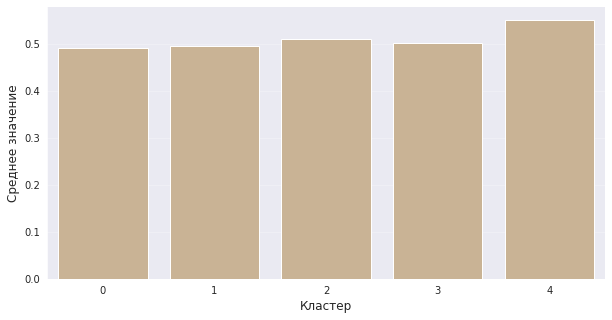

Распределение по кластерам для признака: near_location


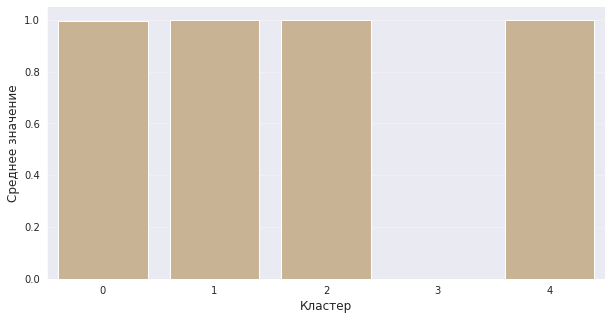

Распределение по кластерам для признака: partner


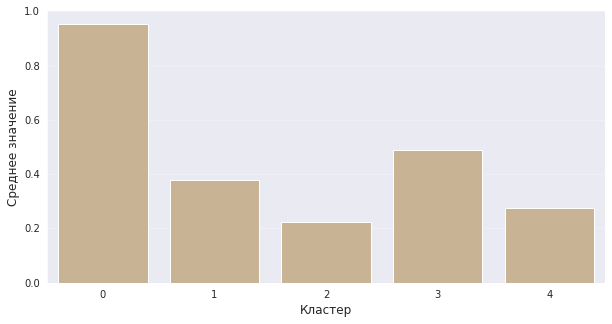

Распределение по кластерам для признака: promo_friends


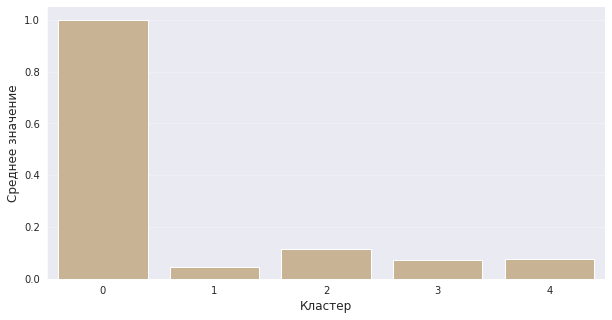

Распределение по кластерам для признака: phone


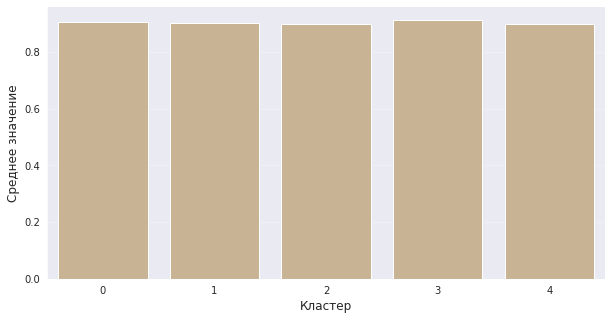

Распределение по кластерам для признака: group_visits


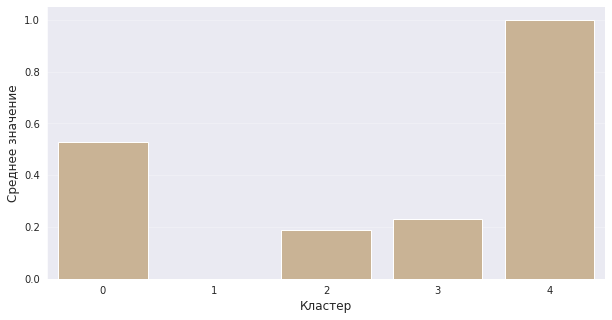

Распределение по кластерам для признака: age


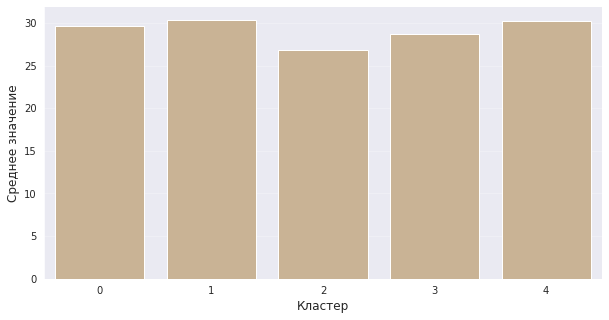

Распределение по кластерам для признака: avg_additional_charges_total


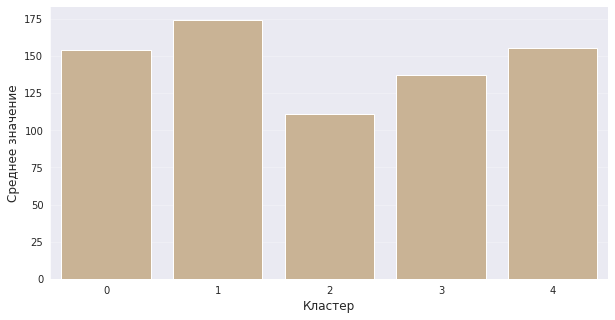

Распределение по кластерам для признака: month_to_end_contract


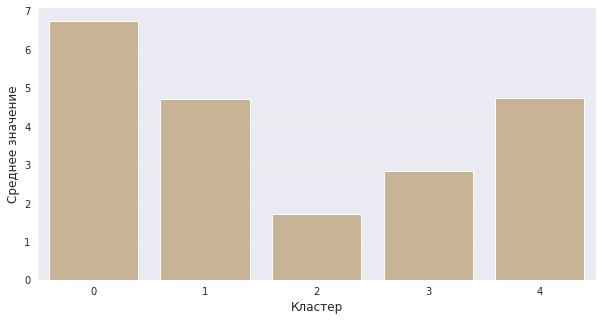

Распределение по кластерам для признака: lifetime


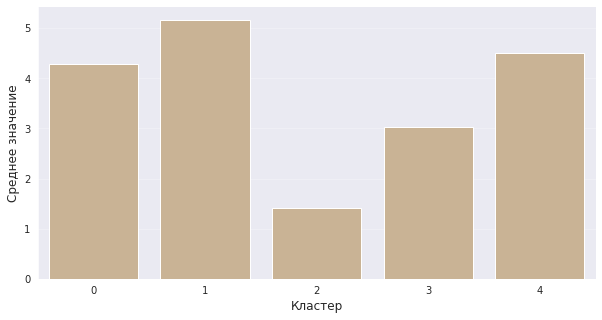

Распределение по кластерам для признака: avg_class_frequency_current_month


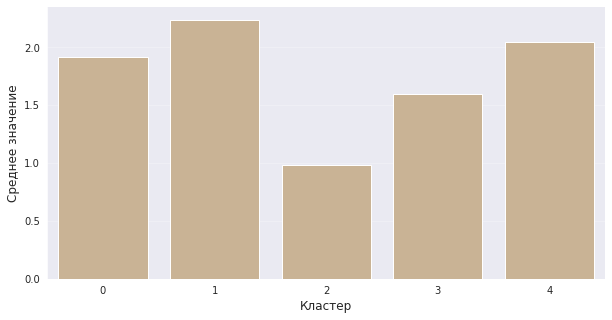

Распределение по кластерам для признака: churn


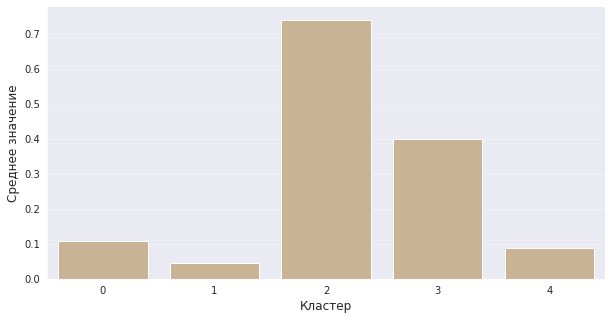

In [17]:
#Сравним средние значения признаков для каждого из кластеров
for col in data_grouped_by_labels.columns:
    print("Распределение по кластерам для признака:", col)
    sns.barplot(data=data, x="labels", y=col, ci=None, color='tan')
    plt.xlabel('Кластер')
    plt.ylabel('Среднее значение')
    sns.despine()
    plt.show()


Клиенты из кластера "3" живут далеко от центра. Клиенты из кластеров "0" и "3" чаще имеют партнера. Клиенты из кластера "0" часто приходят по promo от друзей. Клиенты из кластеров "0" и "4" чаще совершают групповые визиты. Клиенты из кластеров "2" и "3" обычно моложе других. Клиенты из кластера "1" чаще расходуют дополнительные средства. В среднем, клиенты из кластеров "2" и "3" имеют наименьшее количетство месяцев до конца контракта, и задерживаются в центре не дольше чем на 3 месяца, а также посещают центр реже других в текущем месяце.

Распределение значений для признака: gender


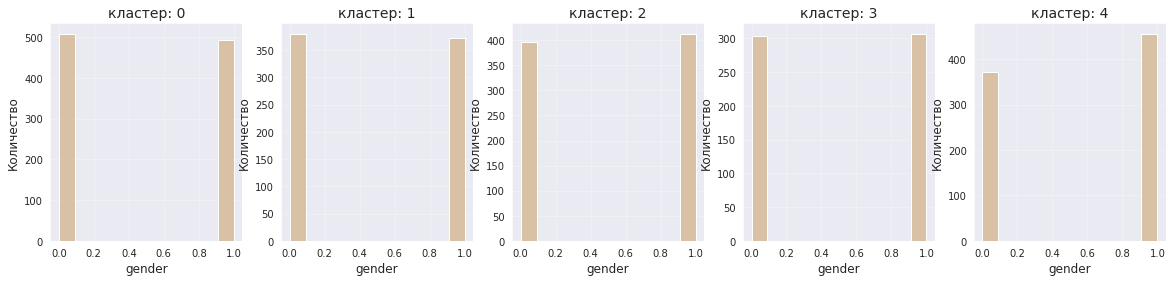

Распределение значений для признака: near_location


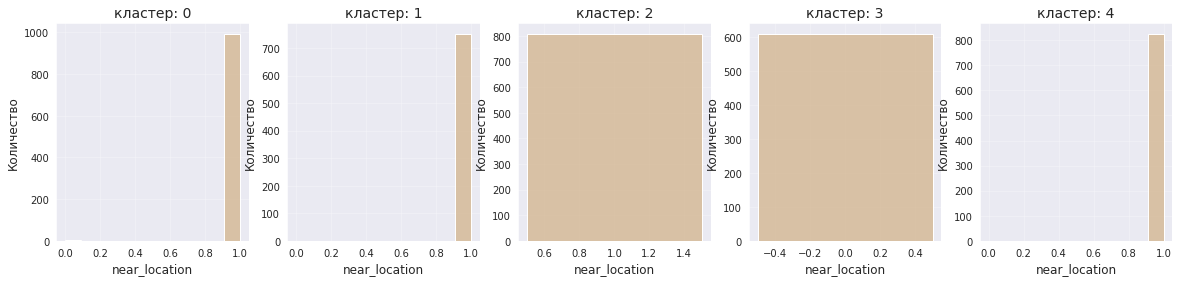

Распределение значений для признака: partner


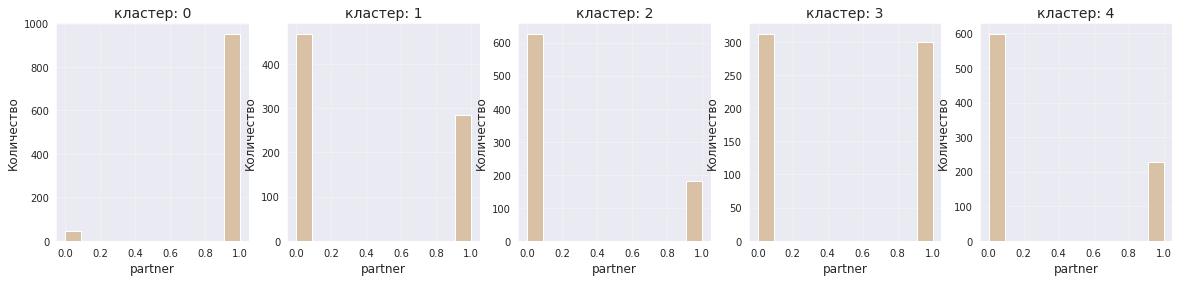

Распределение значений для признака: promo_friends


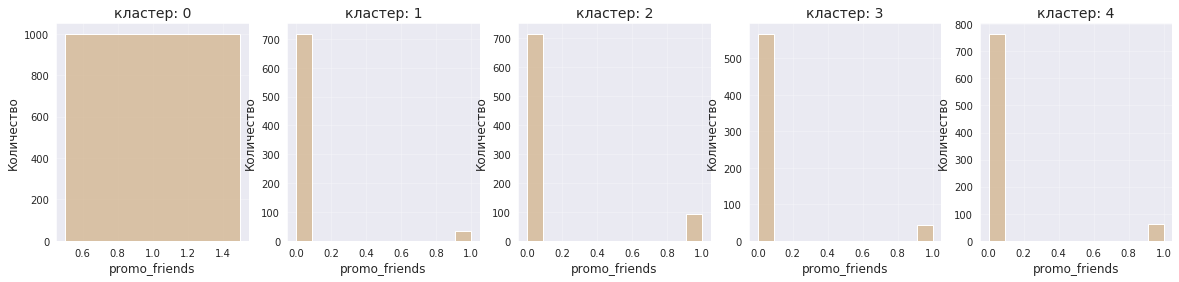

Распределение значений для признака: phone


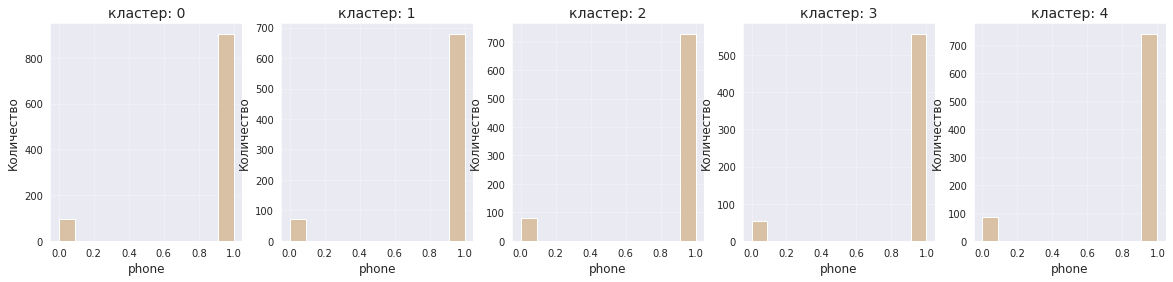

Распределение значений для признака: group_visits


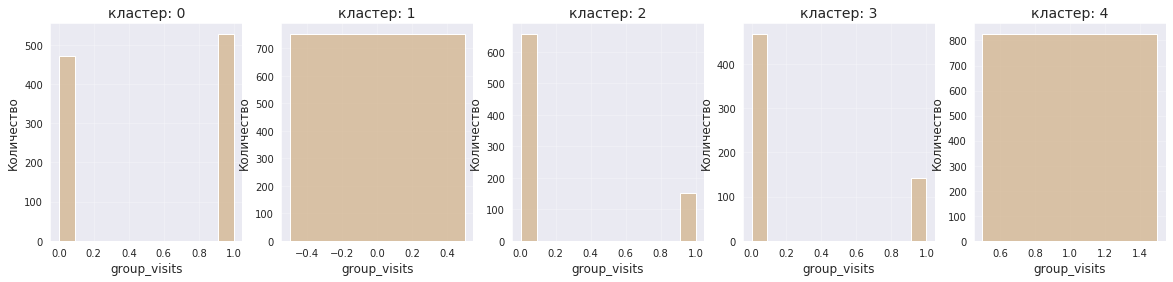

Распределение значений для признака: age


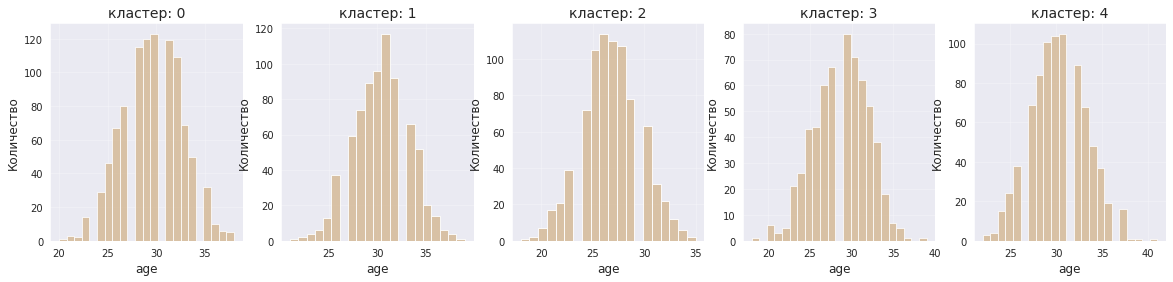

Распределение значений для признака: avg_additional_charges_total


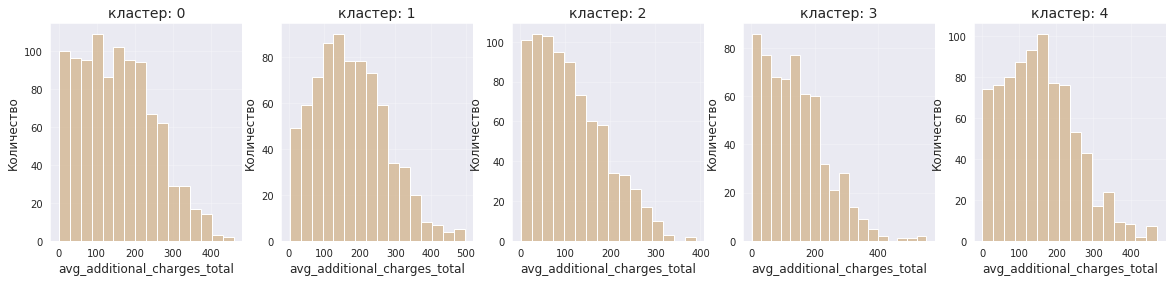

Распределение значений для признака: month_to_end_contract


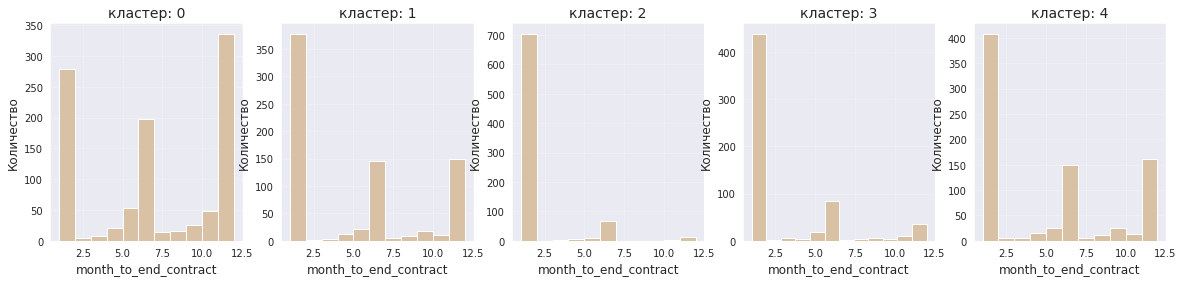

Распределение значений для признака: lifetime


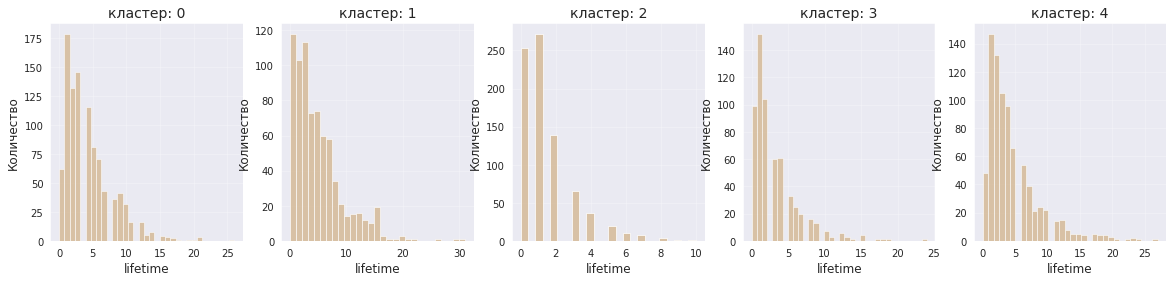

Распределение значений для признака: avg_class_frequency_current_month


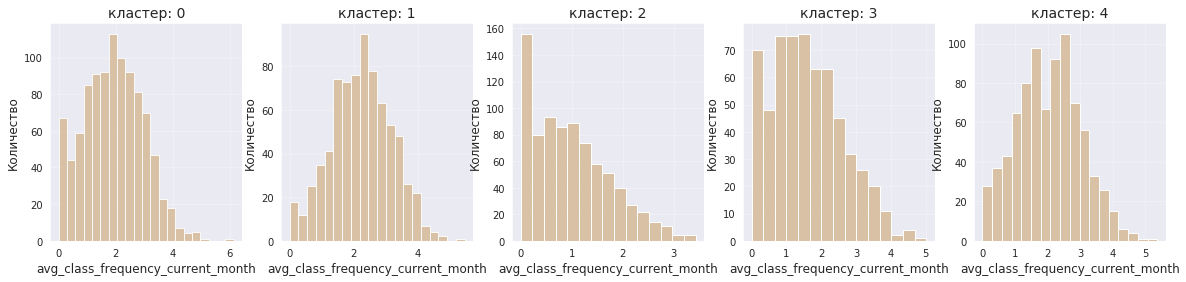

Распределение значений для признака: churn


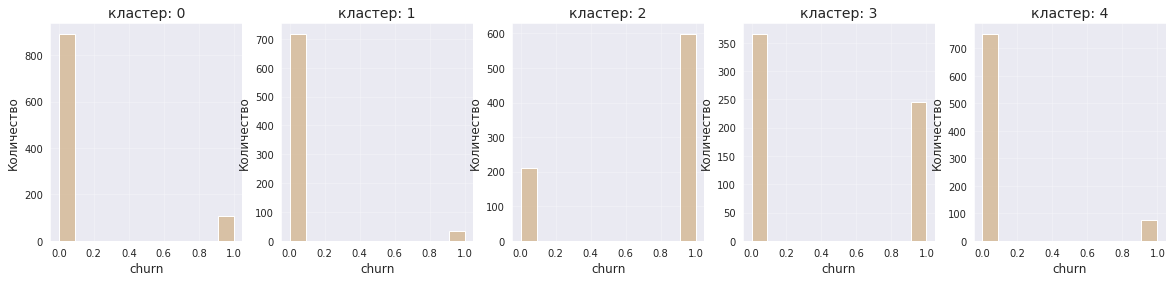

In [18]:
#Создадим визуализацию распределения для каждого из признаков
for col in data_grouped_by_labels.columns:
    print("Распределение значений для признака:", col)
    plt.figure(figsize=(20,4))
    plt.subplot(1, 5, 1)
    sns.histplot(data[data['labels'] == 0][col], color='tan')
    plt.title('кластер: 0')
    plt.ylabel('Количество')
    plt.subplot(1, 5, 2)
    sns.histplot(data[data['labels'] == 1][col], color='tan')
    plt.title('кластер: 1')
    plt.ylabel('Количество')
    plt.subplot(1, 5, 3)
    sns.histplot(data[data['labels'] == 2][col], color='tan')
    plt.title('кластер: 2')
    plt.ylabel('Количество')
    plt.subplot(1, 5, 4)
    sns.histplot(data[data['labels'] == 3][col], color='tan')
    plt.title('кластер: 3')
    plt.ylabel('Количество')
    plt.subplot(1, 5, 5)
    sns.histplot(data[data['labels'] == 4][col], color='tan')
    plt.title('кластер: 4')
    plt.ylabel('Количество')
    plt.show()

Клиенты из кластеров "2" и "3" чаще других живут далеко от центра. В кластерах "0" и "3" чаще бывает партнер, чем в других. У клиентов из кластеров "0" и "3" чаще бывает партнер. Наибольшее количество месяцев до конца контракта у клиентов из кластера "0", затем идут клиенты из кластеров "1" и "4".

### <a id='section45'>4.5 Отток по кластерам</a><br>

In [19]:
# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('labels')[['churn']].mean()

,churn
labels,
0,0.108000
1,0.046481
2,0.740420
3,0.400982
4,0.089480


Ряд признаков одинаков для всех кластеров, но некоторые признаки различаются. Кластер под номером "2" особенно сильно подвержен оттоку (0.74). Менее склонен к оттоку кластер номер "3" (0.40), другие кластеры относительно надежны (<0.11).

## <a id='section5'>Выводы и рекомендации</a><br>

При планировании маркетинговых активностей необходимо исключить из таргетинга:

- находящихся на значительном расстоянии потенциальных клиентов

- студентов и другую неплатежеспособную аудиторию

- людей, которые не совершают групповые визиты и не имеют постоянного партнера


Поскольку менее подвержены оттоку клиенты, которые имеют продолжительные контракты и посещают центр активно, необходимо продумать способы вовлечения и удержания текущей аудитории за счет:

- системы вознаграждения за приведенных друзей

- более разнообразной программы предлагаемых активностей

- более гибкого графика предлагаемых активностей

- улучшения оборудования в центре


Клиенты с непродолжительными контрактами чаще других переходят в отток, поэтому нужно:

- исключить короткие контракты или сделать их невыгодными

- предложить более гибкие условия рассрочки платежей

- изменить тарифные планы, сделав контракты-конструкторы более гибкими (платишь меньше, но именно за те активности, которые тебе интересны)
